In [1]:
# Copyright 2023 Teledyne Signal Processing Devices Sweden AB
""" P2P streaming ADQ -> GPU in python """
import pyadq
from typing import List, Tuple
import cupy as cp
import settings as s
import ctypes as ct
import streaming_helpers as sh
import helper_cupy as hc
import gdrapi as g
from gdrapi import gdr_check_error_exit_func
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

gdrapi = g.GdrApi()


def allocate_and_pin_buffer(
    buffer_size: int,
    memory_handle: g.GdrMemoryHandle,
    gdr: g.Gdr,
    bar_ptr_data: sh.BarPtrData,
) -> Tuple[ct.c_void_p, ct.c_uint64, cp.ndarray]:
    """Allocate and pin buffers.

    Args:
        `buffer_size`: Size to allocate on GPU.
        `memory_handle`: Wrapped memory_handle struct from gdrapi.
        `gdr`: Wrapped gdr object from gdrapi.
        `bar_ptr_data`: Pointer to data on bar.

    Returns:
        `buffer_pointer`: Pointer to GPU buffer.
        `buffer_address`: Physical address to buffer.
        `buffer`: Buffer object.
    """
    info = g.GdrInfo()

    buffer_size = (buffer_size + g.GPU_PAGE_SIZE - 1) & g.GPU_PAGE_MASK
    buffer = cp.zeros(buffer_size // 2, dtype=cp.short)  # Allocate memory in GPU
    buffer_ptr = buffer.data.ptr  # Pointer of memory

    # Map device memory buffer on GPU BAR1, returning an handle.
    gdr_status = gdrapi.gdr_pin_buffer(
        gdr, ct.c_ulong(buffer_ptr), buffer_size, 0, 0, ct.byref(memory_handle)
    )
    gdr_check_error_exit_func(gdr_status or (memory_handle == 0), "gdr_pin_buffer")
    # Create a user-space mapping for the BAR1 info, length is bar1->buffer
    gdr_status = gdrapi.gdr_map(gdr, memory_handle, ct.byref(bar_ptr_data), buffer_size)
    gdr_check_error_exit_func(gdr_status or (bar_ptr_data == 0), "gdr_map")
    # Bar physical address will be aligned to the page size before being mapped in user-space
    # so the pointer returned might be affected by an offset.
    # gdr_get_info is used to calculate offset.

    gdr_status = gdrapi.gdr_get_info(gdr, memory_handle, info)

    gdr_check_error_exit_func(gdr_status, "gdr_info")
    offset_data = info.va - buffer_ptr

    buffer_address = ct.c_uint64(info.physical)
    gdr_status = gdrapi.gdr_validate_phybar(gdr, memory_handle)
    gdr_check_error_exit_func(gdr_status, "gdr_validate_phybar")
    buffer_pointer = ct.c_void_p(bar_ptr_data.value + offset_data)

    return buffer_pointer, buffer_address, buffer

def exit(gdr, memory_handles, bar_ptr_data):
    for ch in range(s.NOF_CHANNELS):
        for b in range(s.NOF_GPU_BUFFERS):
            gdrapi.gdr_unmap(
                gdr,
                memory_handles[ch][b],
                bar_ptr_data.pointers[ch][b],
                s.NOF_RECORDS_PER_BUFFER * s.CH0_RECORD_LEN * s.BYTES_PER_SAMPLES,
            )
            gdrapi.gdr_unpin_buffer(gdr, memory_handles[ch][b])
    # Free GPU memory
    mempool = cp.get_default_memory_pool()
    mempool.free_all_blocks()

"""Main streaming function"""
acu: pyadq.ADQControlUnit = pyadq.ADQControlUnit()
# Enable trace logging
acu.ADQControlUnit_EnableErrorTrace(pyadq.LOG_LEVEL_INFO, ".")

# List the available devices
device_list: List[pyadq.ADQInfoListEntry] = acu.ListDevices()

print(f"Found {len(device_list)} device(s)")

# Ensure that at least one device is available
assert device_list

# Set up the first available device
device_to_open = 0
dev: pyadq.ADQ = acu.SetupDevice(device_to_open)

print(f"Setting up data collection for: {dev}")

# Initialize the parameters with default values
parameters: pyadq.ADQParameters = dev.InitializeParameters(pyadq.ADQ_PARAMETER_ID_TOP)
parameters.event_source.periodic.period = s.PERIODIC_EVENT_SOURCE_PERIOD
parameters.event_source.periodic.frequency = s.PERIODIC_EVENT_SOURCE_FREQUENCY

parameters.test_pattern.channel[0].source = s.CH0_TEST_PATTERN_SOURCE
parameters.test_pattern.channel[1].source = s.CH1_TEST_PATTERN_SOURCE

parameters.signal_processing.sample_skip.channel[0].skip_factor = s.CH0_SAMPLE_SKIP_FACTOR
parameters.signal_processing.sample_skip.channel[1].skip_factor = s.CH1_SAMPLE_SKIP_FACTOR
parameters.acquisition.channel[0].nof_records = (
    s.NOF_RECORDS_PER_BUFFER * s.NOF_BUFFERS_TO_RECEIVE
)
parameters.acquisition.channel[0].record_length = s.CH0_RECORD_LEN
parameters.acquisition.channel[0].trigger_source = s.CH0_TRIGGER_SOURCE
parameters.acquisition.channel[0].trigger_edge = s.CH0_TRIGGER_EDGE
parameters.acquisition.channel[0].horizontal_offset = s.CH0_HORIZONTAL_OFFSET

if s.NOF_CHANNELS > 1:
    parameters.acquisition.channel[1].nof_records = (
        s.NOF_RECORDS_PER_BUFFER * s.NOF_BUFFERS_TO_RECEIVE
    )
    parameters.acquisition.channel[1].record_length = s.CH1_RECORD_LEN
    parameters.acquisition.channel[1].trigger_source = s.CH1_TRIGGER_SOURCE
    parameters.acquisition.channel[1].trigger_edge = s.CH1_TRIGGER_EDGE
    parameters.acquisition.channel[1].horizontal_offset = s.CH1_HORIZONTAL_OFFSET

parameters.transfer.common.write_lock_enabled = 1
parameters.transfer.common.transfer_records_to_host_enabled = 0
parameters.transfer.common.marker_mode = pyadq.ADQ_MARKER_MODE_HOST_MANUAL

parameters.transfer.channel[0].record_length_infinite_enabled = 0
parameters.transfer.channel[0].record_size = (
    s.BYTES_PER_SAMPLES * parameters.acquisition.channel[0].record_length
)
parameters.transfer.channel[0].record_buffer_size = (
    s.NOF_RECORDS_PER_BUFFER * parameters.transfer.channel[0].record_size
)
parameters.transfer.channel[0].metadata_enabled = 0
parameters.transfer.channel[0].nof_buffers = s.NOF_GPU_BUFFERS

if s.NOF_CHANNELS > 1:
    parameters.transfer.channel[1].record_length_infinite_enabled = 0
    parameters.transfer.channel[1].record_size = (
        s.BYTES_PER_SAMPLES * parameters.acquisition.channel[1].record_length
    )
    parameters.transfer.channel[1].record_buffer_size = (
        s.NOF_RECORDS_PER_BUFFER * parameters.transfer.channel[1].record_size
    )
    parameters.transfer.channel[1].metadata_enabled = 0
    parameters.transfer.channel[1].nof_buffers = s.NOF_GPU_BUFFERS

# Create pointers, buffers and GDR object
memory_handles = [
    [g.GdrMemoryHandle() for x in range(s.NOF_CHANNELS)] for y in range(s.NOF_GPU_BUFFERS)
]

bar_ptr_data = sh.BarPtrData(s.NOF_CHANNELS, s.NOF_GPU_BUFFERS)
gpu_buffer_ptr = sh.GpuBufferPointers(s.NOF_CHANNELS, s.NOF_GPU_BUFFERS)
gdr = gdrapi.gdr_open()
gpu_buffers = sh.GpuBuffers(
    s.NOF_CHANNELS,
    s.NOF_GPU_BUFFERS,
    s.CH0_RECORD_LEN,
)
gpu_buffer_address = 0

# Allocate GPU buffers
for ch in range(s.NOF_CHANNELS):
    for b in range(s.NOF_GPU_BUFFERS):
        (
            gpu_buffer_ptr.pointers[ch][b],
            gpu_buffer_address,
            gpu_buffers.buffers[ch][b],
        ) = allocate_and_pin_buffer(
            parameters.transfer.channel[ch].record_buffer_size,
            memory_handles[ch][b],
            gdr,
            bar_ptr_data.pointers[ch][b],
        )

        parameters.transfer.channel[ch].record_buffer_bus_address[b] = gpu_buffer_address
        parameters.transfer.channel[ch].record_buffer[b] = gpu_buffer_ptr.pointers[ch][b]
# Configure digitizer parameters
dev.SetParameters(parameters)

# Start timer for measurement
start_time = time.time()
# Start timer for regular printouts
start_print_time = time.time()
print("Start acquiring data")
if dev.ADQ_StartDataAcquisition() == pyadq.ADQ_EOK:
    print("Success")
else:
    print("Failed")

data_transfer_done = 0
nof_buffers_received = [0, 0]
bytes_received = 0
status = pyadq.ADQP2pStatus()._to_ct()
while not data_transfer_done:
    result = dev.ADQ_WaitForP2pBuffers(ct.byref(status), s.WAIT_TIMEOUT_MS)
    if result == pyadq.ADQ_EAGAIN:
        print("Timeout")
    elif result < 0:
        print(f"Failed with retcode {result}")
        exit(1)

    else:
        buf = 0
        while (buf < status.channel[0].nof_completed_buffers) or (
            buf < status.channel[1].nof_completed_buffers
        ):
            for ch in range(s.NOF_CHANNELS):
                if buf < status.channel[ch].nof_completed_buffers:
                    buffer_index = status.channel[ch].completed_buffers[buf]
                    dev.ADQ_UnlockP2pBuffers(ch, (1 << buffer_index))
                    nof_buffers_received[ch] += 1
                    bytes_received += (
                        s.NOF_RECORDS_PER_BUFFER * s.CH0_RECORD_LEN * s.BYTES_PER_SAMPLES
                    )
            buf += 1
        data_transfer_done = nof_buffers_received[1] >= s.NOF_BUFFERS_TO_RECEIVE
        now_time = time.time() - start_time
        print_time = time.time() - start_print_time
        if print_time > 5:
            # Check for overflow, stop if overflow
            overflow_status = dev.GetStatus(pyadq.ADQ_STATUS_ID_OVERFLOW)
            if overflow_status.overflow:
                print("Overflow, stopping data acquisition...")
                dev.ADQ_StopDataAcquisition()
                exit("Exited because of overflow.")

            print("Nof buffers received:", nof_buffers_received)
            print("Total GB received:", bytes_received / 10**9)
            print("Average transfer speed:", bytes_received / 10**9 / now_time)
            start_print_time = time.time()

stop_time = time.time()

gbps = bytes_received / (stop_time - start_time)
dev.ADQ_StopDataAcquisition()
print(f"Total GB received: {bytes_received / 10**9}")

print(f"Total GB/s: {gbps / 10**9}")

if s.PRINT_LAST_BUFFERS:
    data_buffer = np.zeros(
        parameters.transfer.channel[0].record_buffer_size // 2, dtype=np.short
    )
    print(gpu_buffers.buffers[0][0])
    hc.cudaMemcpy(
        data_buffer.ctypes.data,
        gpu_buffers.buffers[1][1].data.ptr,
        parameters.transfer.channel[1].record_buffer_size,
        hc.cudaMemcpyDeviceToHost,
    )

    #data_buffer.tofile("data.bin")
    plt.plot(data_buffer)
    #plt.savefig("SingleBuffer.png")
exit(gdr, memory_handles, bar_ptr_data)




'''
if __name__ == "__main__":
    main()''';


Found 1 device(s)
Setting up data collection for: <ADQ S/N: SPD-10702>
Start acquiring data
Success
Total GB received: 6.7108864
Total GB/s: 4.990200019513257
[17 67 50 ...  0 67 33]
Error in callback <function flush_figures at 0x7f2f2b949940> (for post_execute):


KeyboardInterrupt: 

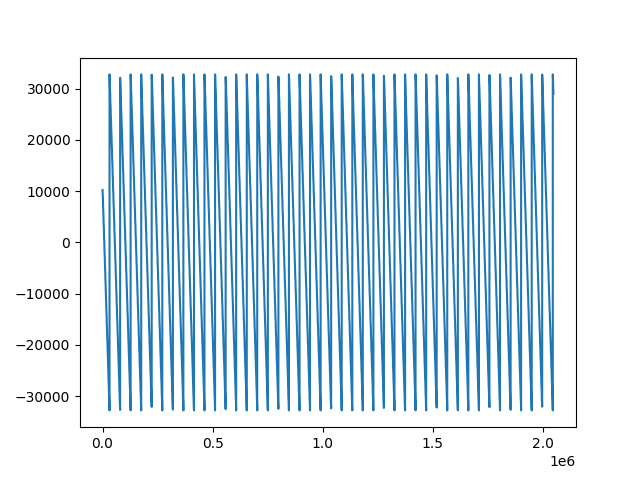

In [12]:
plt.close('all')
plt.figure()
plt.plot(data_buffer)